### Objective:

Build Multi-Class classifier that can classify the tickets by analysing text.
Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks. In the previous milestone we've already covered Data cleaning, preprocessing, Exploratory Data Analysis

Milestone 2: Test the Model, Fine-tuning and Repeat

Test the model and report as per evaluation metrics
Try different models
Try different evaluation metrics
Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc..for these models to fine-tune them
Report evaluation metrics for these models along with your observation on how changing different hyper parameters leads to change in the final evaluation metric.

### Imports and Configurations
Section to import all necessary packages. Install the libraries which are not included in Anaconda distribution by default using pypi channel or conda forge 
```
    pip install ftfy wordcloud goslate spacy plotly cufflinks gensim pyLDAvis
```

```
    conda install -c conda-forge ftfy wordcloud goslate spacy plotly cufflinks gensim pyLDAvis
```
​

In [2]:
# Utilities
from time import time
from PIL import Image
from pprint import pprint
from zipfile import ZipFile
import os, sys, itertools, re, calendar
import warnings, pickle, string, timestring
from IPython.display import IFrame
from ftfy import fix_encoding, fix_text, badness

# Translation APIs
from goslate import Goslate # Provided by Google

# Numerical calculation
import numpy as np

# Data Handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import pyLDAvis
import pyLDAvis.gensim

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU, SpatialDropout1D
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Traditional Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Topic Modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing import preprocessing
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.phrases import Phraser
from gensim.models import Phrases, CoherenceModel

# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# NLP toolkits
import spacy
import nltk
from nltk import tokenize
from nltk.corpus import stopwords

/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.

/Users/gnommer/.virtualenvs/capstone/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and

In [3]:
# Configure for any default setting of any library
nltk.download('stopwords')
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
pyLDAvis.enable_notebook()
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gnommer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <u>Create Word Embbeddings</u>
We've observed poor performance in the 1st milestone, which enables us to create our own word embbeddings. Let's load the preprocessed dataset and use Gensim model to create Word2Vec embbeddings.

Word embedding is one of the most important techniques in natural language processing(NLP), where words are mapped to vectors of real numbers. Word embedding is capable of capturing the meaning of a word in a document, semantic and syntactic similarity, relation with other words.

The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling.

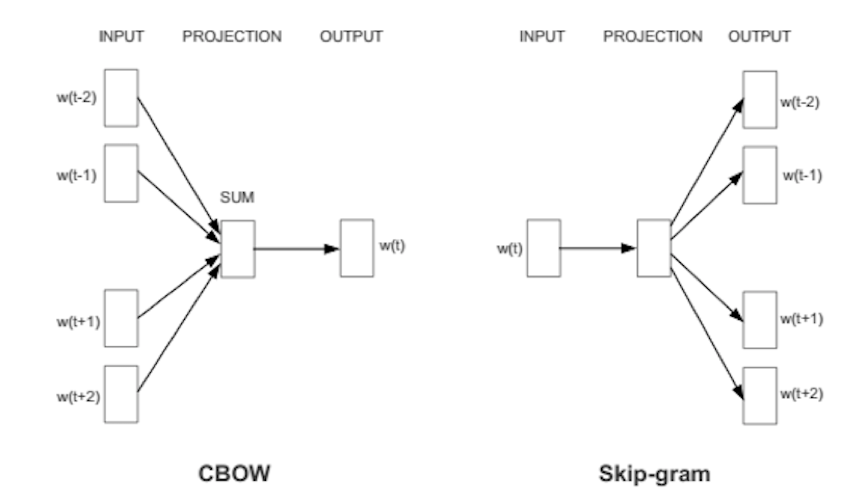

In [30]:
# Load the preprocessed pickle dataset
with open('pickles/preprocessed_ticket.pkl','rb') as handle:
    ticket = pickle.load(handle)
ticket['Summary'] = ticket['Short description'] + ticket['Description']
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Function to create the tokenized sentence
def tokenize_sentences(sentence):
    doc = nlp(sentence)
    return [token.lemma_ for token in doc if token.lemma_ !='-PRON-' and not token.is_stop]

sentence_stream=[]
for sent in ticket.Summary.values.tolist():
    sentence_stream.append(tokenize_sentences(sent))

In [4]:
# Create the Bigram and Trigram models
bigram = Phrases(sentence_stream, min_count=2, threshold=2)
trigram = Phrases(bigram[sentence_stream], min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)
ngram_sentences=[]
for sent in sentence_stream:
    tokens_ = bigram_phraser[sent]
    #print("Bigrams Tokens:\t", tokens_)
    tokens_ = trigram_phraser[tokens_]
    ngram_sentences.append(tokens_)
    
#Serialize bigram and trigram for future
bigram_phraser.save('Models/bigram_mdl_14_03_2020.pkl')
trigram_phraser.save('Models/trigram_mdl_14_03_2020.pkl')

In [5]:
# Create the tagged documents
documents = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(ngram_sentences)]
print("Length of Tagged Documents:",len(documents))
print("Tagged Documents[345]:",documents[345])

Length of Tagged Documents: 8500
Tagged Documents[345]: TaggedDocument(['urgent', 'access', 'rtnzvplq', 'erhmuncq', 'disconnectedreceive', 'email_hi_help', 'error_message', 'server_disconnect', 'edit', 'trgdyyufs', 'calendar', 'invitation', 'calendar', 'calendar_entry', 'possible', 'urgent'], [345])


In [6]:
# Build the Word2Vec model
max_epochs = 100
vec_size = 300
alpha = 0.025
model = Doc2Vec(vector_size=vec_size,window=2,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=2,
                dm =1)
model.build_vocab(documents)

for epoch in range(max_epochs):
    model.train(documents, 
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("Models/d2v_inc_model.mdl")
print("Model Saved")

Model Saved


**Comments**:
Word Embbeddings are generated from the corpus of our tickets dataset and serialized for further use.

### <u>Load the dataset</u>
We've observed poor performance in the 1st milestone, which enables us to introduce 2 more attributes, such as:

- **Shift**: Working shift of the support associate in which the ticket was recieved OR failure occured
- **Lines**: Lines of text present in the ticket description column
Load the searialized dataset stored after 1st milestone's EDA and append the above attributes to them. Also drop sd_len, sd_word_count, desc_len, desc_word_count columns

In [6]:
# Function to determine the Part of the Day (POD)
def get_POD(tkt):
    dt1 = r"(?:\d{1,2}[\/-]){2}\d{4} (?:\d{2}:?){3}"
    dt2 = r"\d{4}(?:[\/-]\d{1,2}){2} (?:\d{2}:?){3}"
    months = '|'.join(calendar.month_name[1:])
    dt3 = fr'[a-zA-Z]+day, (?i:{months}) \d{{1,2}}, \d{{4}} \d{{1,2}}:\d{{1,2}} (?i:am|pm)'
    matches = set(re.findall('|'.join([dt1,dt2,dt3]), tkt))
    if len(matches):
        try:
            hr = timestring.Date(list(matches)[0]).hour
            return 'Morning' if (hr >= 6) and (hr < 18) else 'Night'
        except:
            pass
    return 'General'

In [7]:
# Get POD and lines of Desc from the unprocessed pickle
with open('pickles/translated_ticket.pkl','rb') as handle:
    ticket = pickle.load(handle)

lines = ticket.Description.apply(lambda x: len(str(x).split('\n')))
shifts = ticket[['Short description', 'Description']].agg(lambda x: get_POD(str(x[0]) + str(x[1])), axis=1)
shifts.value_counts()

General    7508
Night       569
Morning     423
dtype: int64

In [8]:
# Load the serialized dataset after milestone-1
with open('pickles/model_ready.pkl','rb') as handle:
    ticket = pickle.load(handle)

# Drop the unwanted columns
ticket.drop(['sd_len','sd_word_count','desc_len','desc_word_count','Caller'], axis=1, inplace=True)
# Insert the new attributes
ticket.insert(loc=ticket.shape[1]-1, column='Shift', value=shifts)
ticket.insert(loc=ticket.shape[1]-1, column='Lines', value=lines)

# Check the head of the dataset
ticket.head()

,Short description,Description,Language,Summary,Shift,Lines,Assignment group
0,login issue,verified user detailsemployee manager name che...,English,login issue verified user detailsemployee mana...,General,5,GRP_0
1,outlook,receive from hmjdrvpb.komuaywn@gmail.com hello...,English,outlook receive from hmjdrvpb.komuaywn@gmail.c...,General,7,GRP_0
2,can not log in to vpn,receive from eylqgodm.ybqkwiam@gmail.com hi i ...,English,can not log in to vpn receive from eylqgodm.yb...,General,7,GRP_0
3,unable to access hrtool page,unable to access hrtool page,English,unable to access hrtool page unable to access ...,General,1,GRP_0
4,error skype,error skype,English,error skype error skype,General,1,GRP_0


#### Observation from Milestone-1
Out of all the models we've tried in Milestone-1, Support Vector Machine (SVM) under statistical ML algorithms and Neural Networks are performing better than all others. The models were highly overfitted and one of the obvious reason was the dataset was highly imbalanced. Ratio of GRP_0 to all others is 47:53 and there are 40 groups having less than or equal to 30 tickets assigned each.

Let's address this problem to fine tune the model accuracy by implementing
- Dealing with imbalanced dataset. 
    - Creating distinctive clusters under GRP_0 and downsampling top clusters
    - Clubbing together all those groups into one which has 30 or less tickets assigned
- Replacing TF-IDF vectorizer technique with word embeddings for statistical ML algorithms.

### <u>Resampling the Imbalanced dataset</u>
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).
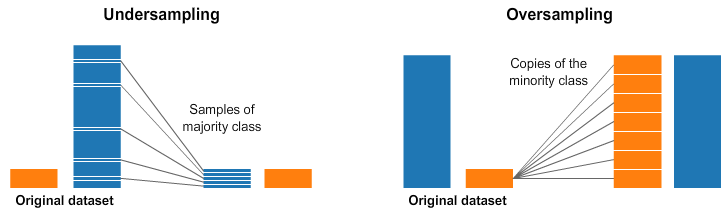


### Topic Modeling
Topic Modeling is a technique to extract the hidden topics from large volumes of text. **Latent Dirichlet Allocation(LDA)** is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package.

Let's first use gensim to implement LDA and find out any distinctive topics among GRP_0, followed by down-sampling the top 3 topics to contain maximum number of tickets created for.

Installation:<br/>
using pypi: **`!pip install gensim`**<br/>
using conda: **`conda install -c conda-forge gensim`**

#### 1. Prepare Stopwords
Used english stopwords from NLTK and extended it to include domain specific frequent words

In [9]:
# Records assigned to only GRP_0
grp0_tickets = ticket[ticket['Assignment group'] == 'GRP_0']

# Prepare NLTK STOPWORDS
STOP_WORDS = stopwords.words('english')
STOP_WORDS.extend(['yes','na','hi','receive','hello','regards','thanks','see','help',
                  'from','greeting','forward','reply','will','please','able'])

#### 2. Tokenize words and Clean-up text
Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [10]:
# Vectorizations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Tokenize the Summary attribute of GRP_0 records
data_words = list(sent_to_words(grp0_tickets['Summary'].values.tolist()))
data_words_nostops = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in data_words]

#### 3. Bigram and Trigram Models
Bigrams and Trigrams are two and three words frequently occurring together respectively in a document.

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = [bigram_mod[doc] for doc in data_words_nostops]

trigram_mod = gensim.models.phrases.Phraser(trigram)
data_words_trigrams = [trigram_mod[doc] for doc in data_words_nostops]

#### 4. Dictionary and Corpus needed for Topic Modeling
Creare the two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

#### 5. Building the Topic Model
Build a Topic Model with top 3 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx+1, topic))
    print()

Topic: 1 
Words: 0.050*"unable" + 0.033*"outlook" + 0.031*"issue" + 0.022*"work" + 0.020*"error" + 0.019*"connect" + 0.017*"open" + 0.016*"get" + 0.016*"skype" + 0.011*"vpn"

Topic: 2 
Words: 0.098*"password" + 0.066*"erp" + 0.060*"reset" + 0.054*"account" + 0.048*"user" + 0.037*"login" + 0.037*"sid" + 0.034*"lock" + 0.017*"unlock" + 0.015*"request"

Topic: 3 
Words: 0.043*"gmail" + 0.042*"com" + 0.026*"access" + 0.020*"company" + 0.019*"update" + 0.015*"email" + 0.013*"ticket" + 0.011*"device" + 0.009*"mobile" + 0.008*"send"



**How to interpret this?**

Topic 1 is a represented as `0.060*"company" + 0.028*"windows" + 0.026*"device" + 0.021*"vpn" + 0.021*"connect" + 0.018*"message" + 0.014*"link" + 0.013*"window" + 0.011*"follow" + 0.011*"use"`

It means the top 10 keywords that contribute to this topic are: ‘company’, ‘windows’, ‘device’.. and so on and the weight of ‘windows’ on topic 1 is 0.028.

The weights reflect how important a keyword is to that topic.

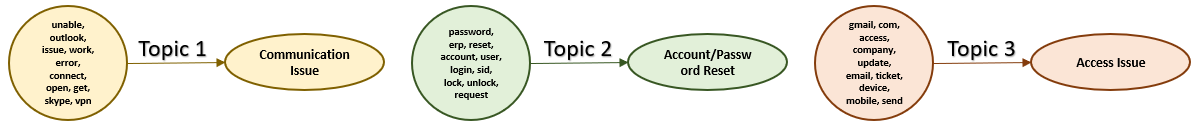

#### 6. Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.80158853743008

Coherence Score:  0.45234512954400746


#### 7. Visualize the topics-keywords
Examine the produced topics and the associated keywords using pyLDAvis.

In [15]:
# Visualize the topics
pyLDAvis.save_html(pyLDAvis.gensim.prepare(lda_model, corpus, id2word), 'lda.html')
IFrame(src='./lda.html', width=1220, height=858)

#### 8. Topic assignment for GRP_0 tickets
Run LDA for each record of GRP_0 to find the associated topic based on the LDA score. As the topic modeling has been trained to accomodate only top 3 topics for entire GRP_0 data, any record scoring less than 50%, we categorize them into 4th(other) topic and such tickets are not the candidates for resampling.

In [16]:
# Function to Determine topic
TOPICS = {1:"Communication Issue", 2:"Account/Password Reset", 3:"Access Issue", 4:"Other Issues"}
def get_groups(text):
    bow_vector = id2word.doc2bow([word for word in simple_preprocess(text) if word not in STOP_WORDS])
    index, score = sorted(lda_model[bow_vector][0], key=lambda tup: tup[1], reverse=True)[0]
    return TOPICS[index+1 if score > 0.5 else 4], round(score, 2)

# Check for a Random record
text = grp0_tickets.reset_index().loc[np.random.randint(0, grp0_tickets.shape[1]),'Summary']
topic, score = get_groups(text)
print("\033[1mText:\033[0m {}\n\033[1mTopic:\033[0m {}\n\033[1mScore:\033[0m {}".format(text, topic, score))

Text: unable to access hrtool page unable to access hrtool page
Topic: Access Issue
Score: 0.5299999713897705


In [17]:
# Apply the function to the dataset
grp0_tickets.insert(loc=grp0_tickets.shape[1]-1, 
                   column='Topic', 
                   value=[get_groups(text)[0] for text in grp0_tickets.Summary])
grp0_tickets.head()

,Short description,Description,Language,Summary,Shift,Lines,Topic,Assignment group
0,login issue,verified user detailsemployee manager name che...,English,login issue verified user detailsemployee mana...,General,5,Account/Password Reset,GRP_0
1,outlook,receive from hmjdrvpb.komuaywn@gmail.com hello...,English,outlook receive from hmjdrvpb.komuaywn@gmail.c...,General,7,Communication Issue,GRP_0
2,can not log in to vpn,receive from eylqgodm.ybqkwiam@gmail.com hi i ...,English,can not log in to vpn receive from eylqgodm.yb...,General,7,Access Issue,GRP_0
3,unable to access hrtool page,unable to access hrtool page,English,unable to access hrtool page unable to access ...,General,1,Access Issue,GRP_0
4,error skype,error skype,English,error skype error skype,General,1,Communication Issue,GRP_0


In [18]:
# Count the records based on Topics
grp0_tickets.Topic.value_counts()

Communication Issue       1312
Account/Password Reset    1309
Access Issue              1017
Other Issues               338
Name: Topic, dtype: int64

**Observations**:
- From the above analysis, it's evident that the tope 3 topics are present in maximum numbers. The ratio of top 3 topics and other topic is $33:33:26:8$
- Except for the Other Issues, rest 3 categories of records can be down sampled to balance the dataset

#### 9. Down-sampling the majority topics under GRP_0
Under-sample the majority class(es) by randomly picking samples with or without replacement. We're using RandomUnderSampler class from imblearn.

In [19]:
# Instantiate the UnderSampler class
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)
# Fit the data
X_res, y_res = sampler.fit_resample(grp0_tickets.drop(['Assignment group','Topic'], axis=1), grp0_tickets.Topic.values)
# Check the ratio of output topics
X_res = pd.DataFrame(X_res, columns=grp0_tickets.drop(['Assignment group','Topic'], axis=1).columns)
y_res = pd.Series(y_res, name="Topic")
y_res.value_counts()

Other Issues              338
Access Issue              338
Account/Password Reset    338
Communication Issue       338
Name: Topic, dtype: int64

**Observation:**<br/>
The output of the UnderSampling technique shows that all the 4 distinct topics are resampled to exactly match the records in each topic making them a perfectly balanced distribution under GRP_0.

Let's combine the Topic and Assignment group columns to maintain a single target attribute.

In [20]:
# Combine Topic and Assignment Group columns
grp0_tickets = pd.concat([X_res, y_res], axis=1)
grp0_tickets['Assignment group'] = grp0_tickets['Topic'].apply(lambda x: f'GRP_0 ({x})')
# Drop the Topic column
grp0_tickets.drop(['Topic'], axis=1, inplace=True)
print(f"\033[1mNew size of GRP_0 tickets:\033[0m {grp0_tickets.shape}")
grp0_tickets.head()

New size of GRP_0 tickets: (1352, 7)


,Short description,Description,Language,Summary,Shift,Lines,Assignment group
0,purchase online catalog detechnical commercial...,purchase online catalog detechnical commercial...,German,purchase online catalog detechnical commercial...,General,1,GRP_0 (Access Issue)
1,uacyltoe hxgaycze ticket,uacyltoe hxgaycze ticket,English,uacyltoe hxgaycze ticket uacyltoe hxgaycze ticket,General,1,GRP_0 (Access Issue)
2,business card request,receive from zqbmxdgy.stuwbacm@gmail.com hello...,English,business card request receive from zqbmxdgy.st...,General,12,GRP_0 (Access Issue)
3,lean event,receive from ikerxqwz.prkyuitl@gmail.com hello...,English,lean event receive from ikerxqwz.prkyuitl@gmai...,General,10,GRP_0 (Access Issue)
4,ticket update on inplant,ticket update on inplant,English,ticket update on inplant ticket update on inplant,General,1,GRP_0 (Access Issue)


#### 10. Club groups with lesser tickets assigned
Combine all groups with less than 25 tickets assigned into one separate group named ***Miscellaneous***

#Groups with less than equal to 25 tickets assigned: 37


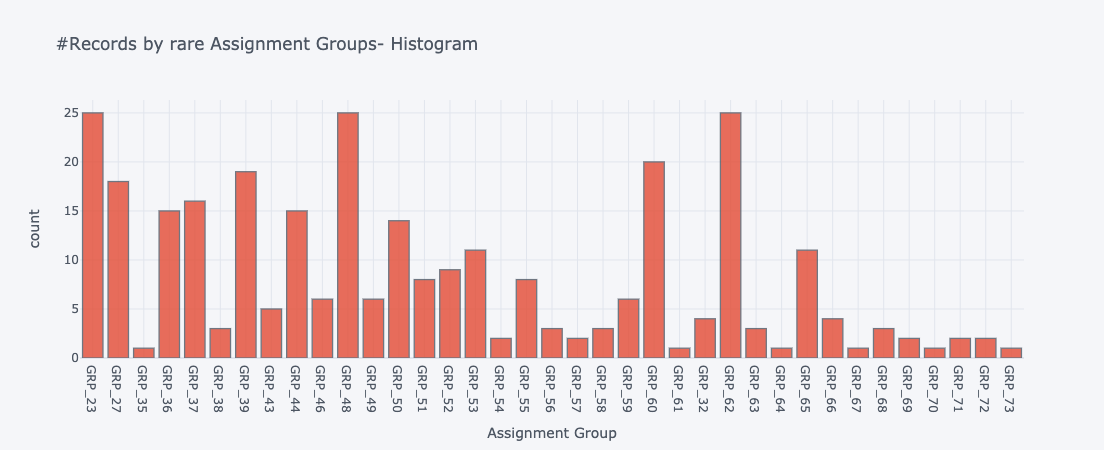

In [21]:
# Find out the Assignment Groups with less than equal to 25 tickets assigned
rare_tickets = ticket.groupby(['Assignment group']).filter(lambda x: len(x) <= 25)
print('\033[1m#Groups with less than equal to 25 tickets assigned:\033[0m', rare_tickets['Assignment group'].nunique())

# Visualize the distribution
rare_tickets['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    colorscale='-orrd',
    title='#Records by rare Assignment Groups- Histogram')

# Rename the Assignment group attribute
rare_tickets['Assignment group'] = 'Miscellaneous'

#### 11. Join and prepare the balanced dataset
Let's club together resampled topics under GRP_0 with Miscellaneous group with less than 25 tickets with all others

In [22]:
# Find tickets with good number of tickets assigned
good_tickets = ticket.iloc[[idx for idx in ticket.index if idx not in rare_tickets.index]]
good_tickets = good_tickets[good_tickets['Assignment group'] != 'GRP_0']

# Join all the 3 datasets
ticket = pd.concat([grp0_tickets, good_tickets, rare_tickets]).reset_index(drop=True)

# Serialize the balanced dataset
with open('Dataset/balanced_ticket.pkl','wb') as f:
    pickle.dump(ticket[['Summary','Assignment group']], f, pickle.HIGHEST_PROTOCOL)

ticket.head()

,Short description,Description,Language,Summary,Shift,Lines,Assignment group
0,purchase online catalog detechnical commercial...,purchase online catalog detechnical commercial...,German,purchase online catalog detechnical commercial...,General,1,GRP_0 (Access Issue)
1,uacyltoe hxgaycze ticket,uacyltoe hxgaycze ticket,English,uacyltoe hxgaycze ticket uacyltoe hxgaycze ticket,General,1,GRP_0 (Access Issue)
2,business card request,receive from zqbmxdgy.stuwbacm@gmail.com hello...,English,business card request receive from zqbmxdgy.st...,General,12,GRP_0 (Access Issue)
3,lean event,receive from ikerxqwz.prkyuitl@gmail.com hello...,English,lean event receive from ikerxqwz.prkyuitl@gmai...,General,10,GRP_0 (Access Issue)
4,ticket update on inplant,ticket update on inplant,English,ticket update on inplant ticket update on inplant,General,1,GRP_0 (Access Issue)


In [54]:
ticket

,Short description,Description,Language,Summary,Shift,Lines,Assignment group
0,ticket update on ticket no,ticket update on ticket no,English,ticket update on ticket no ticket update on ti...,General,1,GRP_0 (Access Issue)
1,delete print job on prtqc,delete print job on prtqc,English,delete print job on prtqc delete print job on ...,General,1,GRP_0 (Access Issue)
2,unable to print from tc ps printer,unable to print from tc ps printer,Chinese,unable to print from tc ps printer unable to p...,General,1,GRP_0 (Access Issue)
3,file shatryung help require,receive from email hi i need to send a video o...,English,file shatryung help require receive from email...,General,5,GRP_0 (Access Issue)
4,problem with start in outlook,receive from email hi can not start on compute...,German,problem with start in outlook receive from ema...,General,29,GRP_0 (Access Issue)
...,...,...,...,...,...,...,...
6585,please turn off eligibility for ethic for user...,please turn off eligibility for ethic for user...,English,please turn off eligibility for ethic for user...,General,1,Miscellaneous
6586,ticket ticket no update to anftgup nftgyair,ticket ticket no update to anftgup nftgyair,English,ticket ticket no update to anftgup nftgyair ti...,General,1,Miscellaneous
6587,micro format,micro format,English,micro format micro format,General,1,Miscellaneous
6588,machine não está funcionando,i be unable to access the machine utility to f...,German,machine não está funcionando i be unable to ac...,General,2,Miscellaneous


#Unique groups remaining: 41


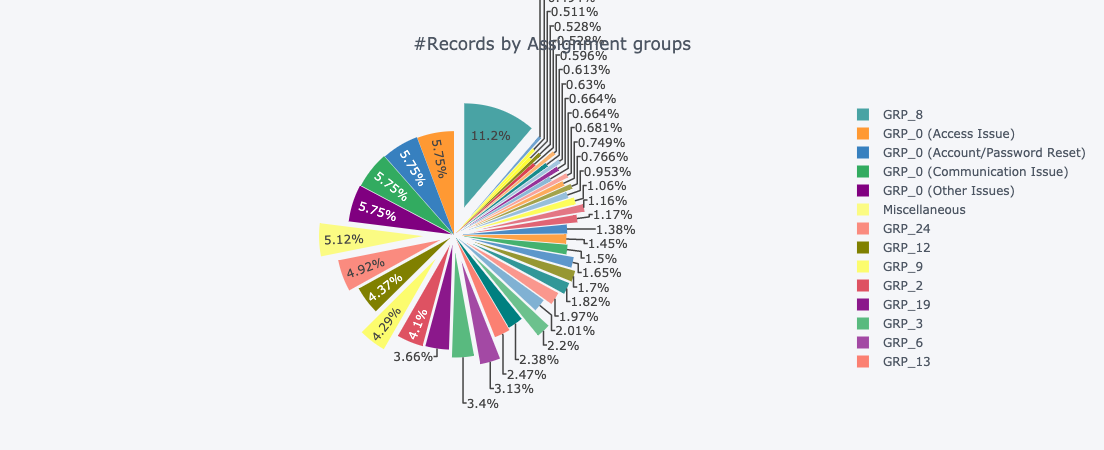

In [23]:
# Visualize the assignment groups distribution
print('\033[1m#Unique groups remaining:\033[0m', ticket['Assignment group'].nunique())
pd.DataFrame(ticket.groupby('Assignment group').size(),columns = ['Count']).reset_index().iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='#Records by Assignment groups',
    pull=np.linspace(0,0.3,ticket['Assignment group'].nunique()))

**Comments:**
- It's evident from the pie chart above the dataset is nearly balanced which can be considered for model building.

## <u>Model Building</u>
Let's load the balanced dataset and Word2Vec model to generate word embbeddings and feed it into LSTM.

### <u>RNN with LSTM networks</u>
Long Short-Term Memory~(LSTM) was introduced by S. Hochreiter and J. Schmidhuber and developed by many research scientists.

To deal with these problems Long Short-Term Memory (LSTM) is a special type of RNN that preserves long term dependency in a more effective way compared to the basic RNNs. This is particularly useful to overcome vanishing gradient problem as LSTM uses multiple gates to carefully regulate the amount of information that will be allowed into each node state. The figure shows the basic cell of a LSTM model.

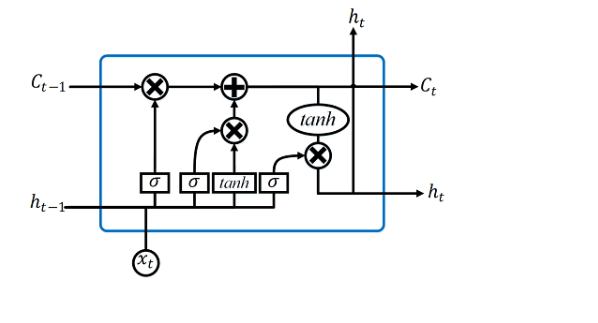

Let's create another column of categorical datatype from Assignment groups. Let's write some generic methods for utilities and to plot evaluation metrics.

In [24]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
timer = Timer()

# A method that plots the Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# A method to train and test the model
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    timer.start()
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))
    print(timer.stop(), 'to run the model')

In [42]:
# Load the balanced dataset
with open('pickles/balanced_ticket.pkl','rb') as f:
    ticket = pickle.load(f)
# Load the Word2Vec model
wmodel = Doc2Vec.load('Models/d2v_inc_model.mdl')

In [43]:
w2v_weights = wmodel.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 12466 - Embedding Dim: 300


In [44]:
def word2token(word):
    try:
        return wmodel.wv.vocab[word].index
    except:
        return 0

In [48]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 100

# Prepare the embbedings with 0's padding to max sequence length
X = ticket.Summary.values.tolist()
set_X=[]
for sent in X:
      set_X.append(np.array([word2token(w) for w in tokenize_sentences(sent[0])[:MAX_SEQUENCE_LENGTH] if w != '']))

set_X = pad_sequences(set_X, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y = pd.get_dummies(ticket['Assignment group']).values
print('Shape of label X:', set_X.shape)
print('Shape of label y:', y.shape)

Shape of label X: (27470, 100)
Shape of label y: (27470, 41)


In [49]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [50]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE()
X, _y = sampler.fit_resample(set_X, y)

In [51]:
# Divide the original dataset into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, _y, test_size=0.3, random_state=47)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19229, 100), (8241, 100), (19229, 41), (8241, 41))

In [52]:
# Visualize a random training sample
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  326,    0,  942,   78,    0,    0,    0,  326,    0,  942,
         78,    8,    0,    1,   33, 1583, 4688,  881,  261,    0,    0,
          0,   14,    0,    0,  119,    0,    0,    0,    0, 1440,    0,
          0, 1018,    0,  645,    0,    0,    0,  115,    0,  186,    0,
          0], dtype=int32)

In [53]:
# CREATE the MODEL

# Samples of categories with less than this number of samples will be ignored
DROP_THRESHOLD = 10000
model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.2))
model_seq.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 17306 samples, validate on 1923 samples
Epoch 1/20
17306/17306 [==============================] - 26s 1ms/step - loss: 2.5079 - accuracy: 0.3479 - val_loss: 1.4905 - val_accuracy: 0.5991
Epoch 2/20
17306/17306 [==============================] - 25s 1ms/step - loss: 1.4242 - accuracy: 0.6140 - val_loss: 0.9954 - val_accuracy: 0.7369
Epoch 3/20
17306/17306 [==============================] - 25s 1ms/step - loss: 1.0731 - accuracy: 0.7079 - val_loss: 0.7677 - val_accuracy: 0.7910
Epoch 4/20
17306/17306 [==============================] - 25s 1ms/step - loss: 0.8559 - accuracy: 0.7641 - val_loss: 0.6312 - val_accuracy: 0.8242
Epoch 5/20
17306/17306 [==============================] - 25s 1ms/step - loss: 0.7293 - accuracy: 0.7968 - val_loss: 0.5446 - val_accuracy: 0.8435
Epoch 6/20
17306/17306 [==============================] - 26s 2ms/step - loss: 0.6361 - accuracy: 0.8209 - val_loss: 0.4743 - val_accuracy: 0.8679
Epoch 7/20
17306/17306 [==============================] - 26s 1ms/ste

In [76]:
## Iteration 1 ...changing the dropout value

model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 16789 samples, validate on 1866 samples
Epoch 1/20
16789/16789 [==============================] - 19s 1ms/step - loss: 3.2495 - accuracy: 0.1479 - val_loss: 2.9664 - val_accuracy: 0.2128
Epoch 2/20
16789/16789 [==============================] - 19s 1ms/step - loss: 2.8697 - accuracy: 0.2274 - val_loss: 2.8250 - val_accuracy: 0.2433
Epoch 3/20
16789/16789 [==============================] - 19s 1ms/step - loss: 2.6985 - accuracy: 0.2679 - val_loss: 2.7589 - val_accuracy: 0.2626
Epoch 4/20
16789/16789 [==============================] - 19s 1ms/step - loss: 2.5748 - accuracy: 0.2933 - val_loss: 2.7286 - val_accuracy: 0.2696
Epoch 5/20
16789/16789 [==============================] - 19s 1ms/step - loss: 2.4592 - accuracy: 0.3222 - val_loss: 2.7159 - val_accuracy: 0.2765
Epoch 6/20
16789/16789 [==============================] - 19s 1ms/step - loss: 2.3718 - accuracy: 0.3473 - val_loss: 2.7038 - val_accuracy: 0.2803
Epoch 7/20
16789/16789 [==============================] - 19s 1ms/ste

In [77]:
## Iteration 2 ..adding more core to LTSM

model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(150, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 16789 samples, validate on 1866 samples
Epoch 1/20
16789/16789 [==============================] - 29s 2ms/step - loss: 3.1951 - accuracy: 0.1613 - val_loss: 2.9223 - val_accuracy: 0.2262
Epoch 2/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.7977 - accuracy: 0.2413 - val_loss: 2.7879 - val_accuracy: 0.2529
Epoch 3/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.6080 - accuracy: 0.2860 - val_loss: 2.7339 - val_accuracy: 0.2755
Epoch 4/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.4571 - accuracy: 0.3238 - val_loss: 2.7210 - val_accuracy: 0.2824
Epoch 5/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.3199 - accuracy: 0.3559 - val_loss: 2.7145 - val_accuracy: 0.2755
Epoch 6/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.1917 - accuracy: 0.3949 - val_loss: 2.7171 - val_accuracy: 0.2862
Epoch 7/20
16789/16789 [==============================] - 28s 2ms/ste

#### Finding Confidence Interval
As this iteration is having more accuracy and no overfitting, let's find out the confidence interval.

8241/8241 [==============================] - 5s 612us/step
Test set
  Loss: 0.278
  Accuracy: 91.991


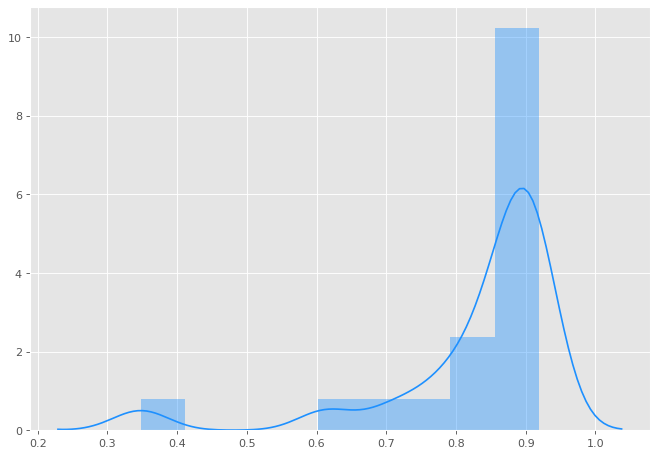

In [54]:
acc = history.history['accuracy']
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(acc, color="dodgerblue", label="Compact")
accr = model_seq.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]*100))

In [40]:
accuracy=0.9276
n = 8241
interval = 1.96 * np.sqrt( (accuracy * (1 - accuracy)) / n)
print(interval*100)

0.5595201963469515


**Observation**:
- There is a 95% likelihood that the confidence interval [92.21, 93.31] covers the true classification of the model on unseen data.

In [80]:
## Iteration 3 ....adding a dense and dropout and batchNormalistaion layer

model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(150, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(150, activation='relu'))
model_seq.add(BatchNormalization(momentum=0.9,epsilon=0.02))
model_seq.add(Dropout(0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 16789 samples, validate on 1866 samples
Epoch 1/20
16789/16789 [==============================] - 29s 2ms/step - loss: 3.2579 - accuracy: 0.1466 - val_loss: 2.9700 - val_accuracy: 0.2053
Epoch 2/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.8751 - accuracy: 0.2226 - val_loss: 2.8291 - val_accuracy: 0.2369
Epoch 3/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.6881 - accuracy: 0.2668 - val_loss: 2.7915 - val_accuracy: 0.2465
Epoch 4/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.5289 - accuracy: 0.3058 - val_loss: 2.7594 - val_accuracy: 0.2583
Epoch 5/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.3944 - accuracy: 0.3349 - val_loss: 2.7553 - val_accuracy: 0.2658
Epoch 6/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.2531 - accuracy: 0.3654 - val_loss: 2.7797 - val_accuracy: 0.2690
Epoch 7/20
16789/16789 [==============================] - 28s 2ms/ste

In [82]:
## iteration 4 ...optimizing adam
from keras.optimizers import Adam

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_seq = Sequential()
model_seq.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_size, 
                        weights=[w2v_weights], 
                        input_length=MAX_SEQUENCE_LENGTH, 
                        mask_zero=True,
                        trainable=False))
model_seq.add(SpatialDropout1D(0.1))
model_seq.add(LSTM(150, dropout=0.1, recurrent_dropout=0.1))
model_seq.add(Dense(150, activation='relu'))
model_seq.add(BatchNormalization(momentum=0.9,epsilon=0.02))
model_seq.add(Dropout(0.1))
model_seq.add(Dense(41, activation='softmax'))
model_seq.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model_seq.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 16789 samples, validate on 1866 samples
Epoch 1/20
16789/16789 [==============================] - 29s 2ms/step - loss: 3.2343 - accuracy: 0.1514 - val_loss: 2.9976 - val_accuracy: 0.1972
Epoch 2/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.8697 - accuracy: 0.2196 - val_loss: 2.8049 - val_accuracy: 0.2390
Epoch 3/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.6943 - accuracy: 0.2610 - val_loss: 2.7550 - val_accuracy: 0.2562
Epoch 4/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.5413 - accuracy: 0.2984 - val_loss: 2.7398 - val_accuracy: 0.2610
Epoch 5/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.3968 - accuracy: 0.3323 - val_loss: 2.7651 - val_accuracy: 0.2690
Epoch 6/20
16789/16789 [==============================] - 28s 2ms/step - loss: 2.2722 - accuracy: 0.3620 - val_loss: 2.7704 - val_accuracy: 0.2701
Epoch 7/20
16789/16789 [==============================] - 29s 2ms/ste

In [85]:
accr = model_seq.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]*100))

7995/7995 [==============================] - 5s 668us/step
Test set
  Loss: 2.853
  Accuracy: 27.767


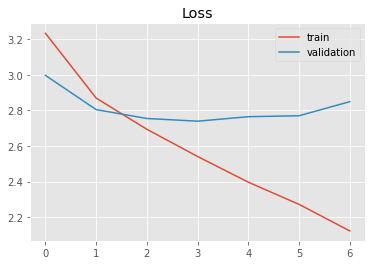

In [86]:
# Data Visualization
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

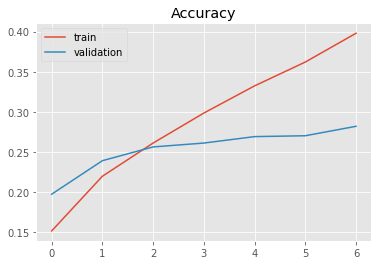

In [89]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

### Summary
The accuracy of each flavors of LSTM model is as follows in the table. This is clear indicative of how LSTM, in the family of RNN is efficient of dealing with textual data.
- We've been able to bump up the model performance upto the range 92.21 to 93.31 with 95% confidence level.
- Making the dataset balanced, helped the model to be trained more accurately.
- Creating our own word embbeddings helped finding better representation of keywords of our corpus.
- Hyperparameter tuning resulted in finding the model with more accuracy without overfitting, which is evident from the train vs. validation accuracy curve.
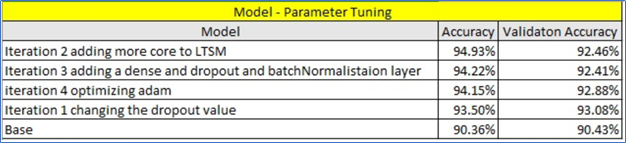

### Automation of Ticket Assignment has following benefits: -
1.	Increase in Customer Satisfaction.
2.	Decrease in the response and resolution time.
3.	Eliminate human error in Ticket Assignment. (Which was ~25% Incidents)
4.	Avoid missing SLAs due to error in Ticket Assignment.
5.	Eliminate any Financial penalty associated with missed SLAs.
6.	Excellent Customer Service.
7.	Reallocate (~1 FTE) requirement for Productive Work. 
8.	Increase in morale of L1 / L2 Team.
9.	Eradicate 15 mins Effort spent for SOP review (~25-30% of Incidents OR 531.25-637.5‬ Person Hours).
10.	Decrease in associated Expense.
11.	L1 / L2 Team can focus on resolving ~54% of the incidents
12.	Functional / L3 teams can focus on resolving ~56% of incidents

**~1 FTE from L1 / L2 Team saved through automating Ticket Assignment can focus on Continuous Improvement activities.
~25% of Incidents which is 2125 additional Incidents will now get resolved within SLA.**

### Additional Business Insights
1. Root cause analysis (RCA) need to be performed on job_scheduler, to understand the cause of failure.
No. of Incident Ticket reduction expected by performing RCA:- 1928. 
22.68% of Total Incident volume of 8500.
Hence, we can reduce the Resource / FTE allocation also by approximately 22.68%.
2. Password Rest process need to be automated.
No. of Incident Ticket reduction expected by automating password reset process:- 1246
14.66% of Total Incident volume of 8500. 
Hence, we can reduce the Resource / FTE allocation also by approximately 14.66%.
Hence a cumulative reduction of 3174 Incidents means 37.34% reduction in Total Incident volume of 8500. 
Hence, cumulative Resource / FTE allocation reduction by approximately 37.34%.
Business can operate at ~62.66% of original Estimates.